In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, BooleanType, DateType, LongType
from pyspark.sql.functions import(
    col, sum, avg, round, when, row_number, 
    year, month, dayofmonth, dayofweek, to_date, current_date,
    trim, coalesce, lower, 
    regexp_replace
)
from pyspark.sql.window import Window

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn



In [0]:
spark = SparkSession.builder.appName("IPL Data Analysis").getOrCreate()

In [0]:
Ball_by_Ball_Schema = StructType([
    StructField("match_id", IntegerType(), True),
    StructField("over_id", IntegerType(), True),
    StructField("ball_id", IntegerType(), True),
    StructField("innings_no", IntegerType(), True),
    StructField("team_batting", IntegerType(), True),
    StructField("team_bowling", IntegerType(), True),
    StructField("striker_batting_position", IntegerType(), True),
    StructField("extra_type", StringType(), True),
    StructField("runs_scored", IntegerType(), True),
    StructField("extra_runs", IntegerType(), True),
    StructField("wides", IntegerType(), True),
    StructField("legbyes", IntegerType(), True),
    StructField("byes", IntegerType(), True),
    StructField("noballs", IntegerType(), True),
    StructField("penalty", IntegerType(), True),
    StructField("bowler_extras", IntegerType(), True),
    StructField("out_type", StringType(), True),
    StructField("caught", BooleanType(), True),
    StructField("bowled", BooleanType(), True),
    StructField("run_out", BooleanType(), True),
    StructField("lbw", BooleanType(), True),
    StructField("retired_hurt", BooleanType(), True),
    StructField("stumped", BooleanType(), True),
    StructField("caught_and_bowled", BooleanType(), True),
    StructField("hit_wicket", BooleanType(), True),
    StructField("obstructingfeild", BooleanType(), True),
    StructField("bowler_wicket", BooleanType(), True),
    StructField("match_date", DateType(), True),
    StructField("season", IntegerType(), True),
    StructField("striker", IntegerType(), True),
    StructField("non_striker", IntegerType(), True),
    StructField("bowler", IntegerType(), True),
    StructField("player_out", IntegerType(), True),
    StructField("fielders", IntegerType(), True),
    StructField("striker_match_sk", IntegerType(), True),
    StructField("strikersk", IntegerType(), True),
    StructField("nonstriker_match_sk", IntegerType(), True),
    StructField("nonstriker_sk", IntegerType(), True),
    StructField("fielder_match_sk", IntegerType(), True),
    StructField("fielder_sk", IntegerType(), True),
    StructField("bowler_match_sk", IntegerType(), True),
    StructField("bowler_sk", IntegerType(), True),
    StructField("playerout_match_sk", IntegerType(), True),
    StructField("battingteam_sk", IntegerType(), True),
    StructField("bowlingteam_sk", IntegerType(), True),
    StructField("keeper_catch", BooleanType(), True),
    StructField("player_out_sk", IntegerType(), True),
    StructField("matchdatesk", DateType(), True)
])

ball_by_Ball_DF = spark.read.csv("/FileStore/tables/IPL Data/Ball_By_Ball.csv", schema=Ball_by_Ball_Schema, header=True)


In [0]:
match_schema = StructType([
    StructField("match_sk", IntegerType(), True),
    StructField("match_id", IntegerType(), True),
    StructField("team1", StringType(), True),
    StructField("team2", StringType(), True),
    StructField("match_date", StringType(), True),
    StructField("season_year", IntegerType(), True),  # "year" type isn't available in PySpark, using IntegerType
    StructField("venue_name", StringType(), True),
    StructField("city_name", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("toss_winner", StringType(), True),
    StructField("match_winner", StringType(), True),
    StructField("toss_name", StringType(), True),
    StructField("win_type", StringType(), True),
    StructField("outcome_type", StringType(), True),
    StructField("manofmach", StringType(), True),
    StructField("win_margin", IntegerType(), True),
    StructField("country_id", IntegerType(), True)
])


match_DF = spark.read.csv('/FileStore/tables/IPL Data/Match.csv', schema=match_schema, header=True)
match_DF = match_DF.withColumn('match_date', to_date(col('match_date'), "M/d/y"))

match_DF.printSchema()


+----------+
|match_date|
+----------+
|2008-04-18|
|2008-04-19|
|2008-04-19|
|2008-04-20|
|2008-04-20|
+----------+
only showing top 5 rows

root
 |-- match_sk: integer (nullable = true)
 |-- match_id: integer (nullable = true)
 |-- team1: string (nullable = true)
 |-- team2: string (nullable = true)
 |-- match_date: date (nullable = true)
 |-- season_year: integer (nullable = true)
 |-- venue_name: string (nullable = true)
 |-- city_name: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- toss_winner: string (nullable = true)
 |-- match_winner: string (nullable = true)
 |-- toss_name: string (nullable = true)
 |-- win_type: string (nullable = true)
 |-- outcome_type: string (nullable = true)
 |-- manofmach: string (nullable = true)
 |-- win_margin: integer (nullable = true)
 |-- country_id: integer (nullable = true)



In [0]:


Player_schema = StructType([
    StructField("player_sk", IntegerType(), True),
    StructField("player_id", IntegerType(), True),
    StructField("player_name", StringType(), True),
    StructField("dob", DateType(), True),  # Date of Birth
    StructField("batting_hand", StringType(), True),  # Left-hand / Right-hand
    StructField("bowling_skill", StringType(), True),  # Bowling type (e.g., Off Spin, Fast)
    StructField("country_name", StringType(), True)  # Player's country
])

palyer_df = spark.read.csv('/FileStore/tables/IPL Data/Player.csv', schema=Player_schema, header=True)

In [0]:
player_match_schema  = StructType([
    StructField("player_match_sk", IntegerType(), True),
    StructField("playermatch_key", IntegerType(), True),
    StructField("match_id", IntegerType(), True),
    StructField("player_id", IntegerType(), True),
    StructField("player_name", StringType(), True),
    StructField("dob", DateType(), True),  # Date of Birth
    StructField("batting_hand", StringType(), True),  # Left-hand / Right-hand
    StructField("bowling_skill", StringType(), True),  # Bowling type (e.g., Off Spin, Fast)
    StructField("country_name", StringType(), True),
    StructField("role_desc", StringType(), True),  # Player's role (e.g., All-rounder, Bowler, Batsman)
    StructField("player_team", StringType(), True),  # Player's team in that match
    StructField("opposit_team", StringType(), True),  # Opponent team
    StructField("season_year", IntegerType(), True),  # Year of the season (PySpark does not have a "Year" type)
    StructField("is_manofthematch", BooleanType(), True),  # True if player won Man of the Match
    StructField("age_as_on_match", IntegerType(), True),  # Player's age during the match
    StructField("isplayers_team_won", BooleanType(), True),  # True if player's team won
    StructField("batting_status", StringType(), True),  # Batting order/status (e.g., Opener, Middle Order)
    StructField("bowling_status", StringType(), True),  # Bowling role (e.g., Opening, Death Over)
    StructField("player_captain", StringType(), True),  # Player's captain
    StructField("opposit_captain", StringType(), True),  # Opponent team captain
    StructField("player_keeper", StringType(), True),  # Player's wicketkeeper status
    StructField("opposit_keeper", StringType(), True)  # Opponent team's wicketkeeper
])

player_match_df = spark.read.csv('/FileStore/tables/IPL Data/Player_match.csv', schema=player_match_schema, header= True)

In [0]:
Team_schema = 'team_sk int, team_id int, team_name string'

team_df = spark.read.format('csv').schema(Team_schema).option('header', True).load('/FileStore/tables/IPL Data/Team.csv')

In [0]:
ball_by_Ball_DF.show(truncate=False)

+--------+-------+-------+----------+------------+------------+------------------------+----------+-----------+----------+-----+-------+----+-------+-------+-------------+--------------+------+------+-------+-----+------------+-------+-----------------+----------+----------------+-------------+----------+------+-------+-----------+------+----------+--------+----------------+---------+-------------------+-------------+----------------+----------+---------------+---------+------------------+--------------+--------------+------------+-------------+-----------+
|match_id|over_id|ball_id|innings_no|team_batting|team_bowling|striker_batting_position|extra_type|runs_scored|extra_runs|wides|legbyes|byes|noballs|penalty|bowler_extras|out_type      |caught|bowled|run_out|lbw  |retired_hurt|stumped|caught_and_bowled|hit_wicket|obstructingfeild|bowler_wicket|match_date|season|striker|non_striker|bowler|player_out|fielders|striker_match_sk|strikersk|nonstriker_match_sk|nonstriker_sk|fielder_match_s

In [0]:
# Filter to include only valid deliveries when wides and no balls equal 0 
valid_Ball = ball_by_Ball_DF.filter((col('wides') == 0) & (col('noballs') == 0))

# Aggregation: Calculate the total and average runs scored in each match and inning

agg_match_inning = valid_Ball.groupBy('match_id', 'innings_no').agg(
    sum('runs_scored').alias('total_runs_scored')
    ,round(avg('runs_scored'),4).alias('avg_runs_scored'))

agg_match_inning.orderBy('match_id', 'innings_no').show()

+--------+----------+-----------------+---------------+
|match_id|innings_no|total_runs_scored|avg_runs_scored|
+--------+----------+-----------------+---------------+
|  335987|         1|              205|         1.7083|
|  335987|         2|               63|         0.6923|
|  335988|         1|              230|         1.9167|
|  335988|         2|              196|         1.6333|
|  335989|         1|              118|         0.9833|
|  335989|         2|              122|         1.3407|
|  335990|         1|              154|         1.2833|
|  335990|         2|              161|         1.3644|
|  335991|         1|              100|         0.8929|
|  335991|         2|               84|         0.7368|
|  335992|         1|              161|         1.3529|
|  335992|         2|              151|         1.3853|
|  335993|         1|              131|         1.0917|
|  335993|         2|              131|         1.6795|
|  335994|         1|              185|         

In [0]:
# Window Function: Calculate running total of runs in each match for each over

windowSpec = Window.partitionBy('match_id', 'innings_no').orderBy('over_id')

ball_by_Ball_DF = ball_by_Ball_DF.withColumn('runs_running_Total', sum('runs_scored').over(windowSpec))


In [0]:
# Conditional Column: Flag for high impact balls (either a wicket or more than 6 runs including extras)

ball_by_Ball_DF = ball_by_Ball_DF.withColumn(
                'High impact', 
                 when((col("runs_scored") + col("extra_runs") > 6) | (col("bowler_wicket") == True), True).otherwise(False))


ball_by_Ball_DF.show(5)

+--------+-------+-------+----------+------------+------------+------------------------+----------+-----------+----------+-----+-------+----+-------+-------+-------------+--------------+------+------+-------+-----+------------+-------+-----------------+----------+----------------+-------------+----------+------+-------+-----------+------+----------+--------+----------------+---------+-------------------+-------------+----------------+----------+---------------+---------+------------------+--------------+--------------+------------+-------------+-----------+------------------+-----------+
|match_id|over_id|ball_id|innings_no|team_batting|team_bowling|striker_batting_position|extra_type|runs_scored|extra_runs|wides|legbyes|byes|noballs|penalty|bowler_extras|      out_type|caught|bowled|run_out|  lbw|retired_hurt|stumped|caught_and_bowled|hit_wicket|obstructingfeild|bowler_wicket|match_date|season|striker|non_striker|bowler|player_out|fielders|striker_match_sk|strikersk|nonstriker_match_s

In [0]:
# Extracting year, month, and day from the match date for more detailed time-based analysis
match_DF = match_DF.withColumn('year', year('match_date'))
match_DF = match_DF.withColumn('month' , month('match_date'))
match_DF = match_DF.withColumn('dayofMonth' , dayofmonth('match_date'))

# High margin win: categorizing win margins into 'high', 'medium', and 'low'

match_DF = match_DF.withColumn('win_margin_category',
                               when(col('win_margin') >= 100 , 'High')
                               .when((col('win_margin') < 100) & (col('win_margin') >= 50 ) , 'Medium').otherwise('Low'))

# Analyze the impact of the toss: who wins the toss and the match

match_DF = match_DF.withColumn('toss_match_winner',
                               when(col('toss_winner') == col('match_winner'), 'Yes').otherwise('No'))

match_DF.columns

Out[86]: ['match_sk',
 'match_id',
 'team1',
 'team2',
 'match_date',
 'season_year',
 'venue_name',
 'city_name',
 'country_name',
 'toss_winner',
 'match_winner',
 'toss_name',
 'win_type',
 'outcome_type',
 'manofmach',
 'win_margin',
 'country_id',
 'year',
 'month',
 'dayofMonth',
 'win_margin_category',
 'toss_match_winner']

In [0]:
# Drop dob column
palyer_df = palyer_df.drop(col('dob'))

# Normalize and clean player names
palyer_df = palyer_df.withColumn('player_name', lower(regexp_replace('player_name', '[^a-zA-Z0-9 ]', '')) )

# Handle missing values in 'batting_hand' and 'bowling_skill' with a default 'unknown'

palyer_df = palyer_df.fillna({
    'batting_hand': 'UnKnown',
    'bowling_skill' : 'UnKnown'
})

# Categorizing players based on batting hand
palyer_df = palyer_df.withColumn('Hand_Category',
                                 when((col('batting_hand').contains('Left')), 'Left').otherwise('Right')
)

palyer_df.show(100, truncate=False)


+---------+---------+----------------+--------------+----------------------+------------+-------------+
|player_sk|player_id|player_name     |batting_hand  |bowling_skill         |country_name|Hand_Category|
+---------+---------+----------------+--------------+----------------------+------------+-------------+
|0        |1        |sc ganguly      |Left-hand bat |Right-arm medium      |India       |Left         |
|1        |2        |bb mccullum     |Right-hand bat|Right-arm medium      |New Zealand |Right        |
|2        |3        |rt ponting      |Right-hand bat|Right-arm medium      |Australia   |Right        |
|3        |4        |dj hussey       |Right-hand bat|Right-arm offbreak    |Australia   |Right        |
|4        |5        |mohammad hafeez |Right-hand bat|Right-arm offbreak    |Pakistan    |Right        |
|5        |6        |r dravid        |Right-hand bat|Right-arm offbreak    |India       |Right        |
|6        |7        |w jaffer        |Right-hand bat|Right-arm o

In [0]:
#Rename 'dob' column
player_match_df = player_match_df.withColumnRenamed('dob', 'date_of_birth')

# Add a 'veteran_status' column based on player age
player_match_df = player_match_df.withColumn('veteran_status',
                                             when(col('age_as_on_match') >= 35, 'veteran').otherwise('not-veteran') )

# Dynamic column to calculate years since debut
player_match_df = player_match_df.withColumn('years_since_debut',
                                            (year(current_date()) - col('season_year')))

# Show the enriched DataFrame
player_match_df.select('years_since_debut').show(5)

+-----------------+
|years_since_debut|
+-----------------+
|               17|
|               17|
|               17|
|               17|
|               17|
+-----------------+
only showing top 5 rows



# SQL 

In [0]:
# Create temp views

ball_by_Ball_DF.createOrReplaceTempView('ball_By_Ball')
match_DF.createOrReplaceTempView('match')
player_match_df.createOrReplaceTempView('player_match')
palyer_df.createOrReplaceTempView('player')
team_df.createOrReplaceTempView('team')

In [0]:
top_scoring_batsmen_per_season = spark.sql("""
SELECT 
p.player_name,
m.season_year,
SUM(b.runs_scored) AS total_runs 
FROM ball_by_ball b
JOIN match m ON b.match_id = m.match_id   
JOIN player_match pm ON m.match_id = pm.match_id AND b.striker = pm.player_id     
JOIN player p ON p.player_id = pm.player_id
GROUP BY p.player_name, m.season_year
ORDER BY m.season_year, total_runs DESC
""")

top_scoring_batsmen_per_season.show()

+-------------+-----------+----------+
|  player_name|season_year|total_runs|
+-------------+-----------+----------+
|     se marsh|       2008|       616|
|    g gambhir|       2008|       534|
|st jayasuriya|       2008|       514|
|    sr watson|       2008|       468|
|     gc smith|       2008|       441|
| ac gilchrist|       2008|       436|
|    yk pathan|       2008|       435|
|     sk raina|       2008|       421|
|     ms dhoni|       2008|       414|
|     v sehwag|       2008|       406|
|    rg sharma|       2008|       404|
|     r dravid|       2008|       371|
|   sc ganguly|       2008|       349|
|     s dhawan|       2008|       340|
|   rv uthappa|       2008|       320|
|kc sangakkara|       2008|       320|
|    dj hussey|       2008|       319|
|  sa asnodkar|       2008|       311|
|     pa patel|       2008|       302|
| yuvraj singh|       2008|       299|
+-------------+-----------+----------+
only showing top 20 rows



In [0]:
economical_bowlers_powerplay = spark.sql("""
SELECT 
p.player_name, 
round(AVG(b.runs_scored), 3) AS avg_runs_per_ball, 
COUNT(b.bowler_wicket) AS total_wickets
FROM ball_by_ball b
JOIN player_match pm ON b.match_id = pm.match_id AND b.bowler = pm.player_id
JOIN player p ON pm.player_id = p.player_id
WHERE b.over_id <= 6
GROUP BY p.player_name
HAVING COUNT(*) >= 1
ORDER BY avg_runs_per_ball, total_wickets DESC
""")
economical_bowlers_powerplay.show()

+---------------+-----------------+-------------+
|    player_name|avg_runs_per_ball|total_wickets|
+---------------+-----------------+-------------+
|     sm harwood|            0.316|           19|
|        a zampa|            0.429|            7|
|     avesh khan|              0.5|           12|
|     ankit soni|              0.5|            6|
|      gr napier|              0.5|            6|
|       aj finch|              0.5|            6|
|       nb singh|             0.56|           25|
|     ag murtaza|            0.646|           79|
|     fh edwards|            0.659|           82|
|      sb bangar|            0.667|           18|
|     d du preez|            0.667|           18|
|        s gopal|            0.667|            6|
|   kp pietersen|              0.7|           20|
|  la carseldine|            0.714|            7|
|      ss mundhe|            0.714|            7|
|       a kumble|            0.761|          109|
|       umar gul|            0.762|           42|


In [0]:
toss_impact_individual_matches = spark.sql("""
SELECT m.match_id, m.toss_winner, m.toss_name, m.match_winner,
       CASE WHEN m.toss_winner = m.match_winner THEN 'Won' ELSE 'Lost' END AS match_outcome
FROM match m
WHERE m.toss_name IS NOT NULL
ORDER BY m.match_id
""")
toss_impact_individual_matches.show()

+--------+--------------------+---------+--------------------+-------------+
|match_id|         toss_winner|toss_name|        match_winner|match_outcome|
+--------+--------------------+---------+--------------------+-------------+
|  335987|Royal Challengers...|    field|Kolkata Knight Ri...|         Lost|
|  335988| Chennai Super Kings|      bat| Chennai Super Kings|          Won|
|  335989|    Rajasthan Royals|      bat|    Delhi Daredevils|         Lost|
|  335990|      Mumbai Indians|      bat|Royal Challengers...|         Lost|
|  335991|     Deccan Chargers|      bat|Kolkata Knight Ri...|         Lost|
|  335992|     Kings XI Punjab|      bat|    Rajasthan Royals|         Lost|
|  335993|     Deccan Chargers|      bat|    Delhi Daredevils|         Lost|
|  335994|      Mumbai Indians|    field| Chennai Super Kings|         Lost|
|  335995|    Rajasthan Royals|    field|    Rajasthan Royals|          Won|
|  335996|      Mumbai Indians|    field|     Kings XI Punjab|         Lost|

In [0]:

average_runs_in_wins = spark.sql("""
SELECT p.player_name, AVG(b.runs_scored) AS avg_runs_in_wins, COUNT(*) AS innings_played
FROM ball_by_ball b
JOIN player_match pm ON b.match_id = pm.match_id AND b.striker = pm.player_id
JOIN player p ON pm.player_id = p.player_id
JOIN match m ON pm.match_id = m.match_id
WHERE m.match_winner = pm.player_team
GROUP BY p.player_name
ORDER BY avg_runs_in_wins ASC
""")
average_runs_in_wins.show()

+---------------+-------------------+--------------+
|    player_name|   avg_runs_in_wins|innings_played|
+---------------+-------------------+--------------+
|       i sharma|                0.0|             1|
|smsm senanayake|                0.0|             1|
|     kp appanna|                0.0|             1|
|      jj bumrah|                0.0|             3|
|       j theron|                0.0|             2|
|       ts mills|                0.0|             3|
|        a nehra|                0.0|             2|
|       vr aaron|                0.0|             5|
|      sn thakur|                0.0|             2|
|  anirudh singh|                0.0|             1|
|     t thushara|                0.2|             5|
|      sa abbott|               0.25|             4|
|  yashpal singh|                0.3|            20|
|    kc cariappa| 0.3333333333333333|             3|
|    s sreesanth| 0.3333333333333333|             3|
|     jd unadkat|                0.4|         

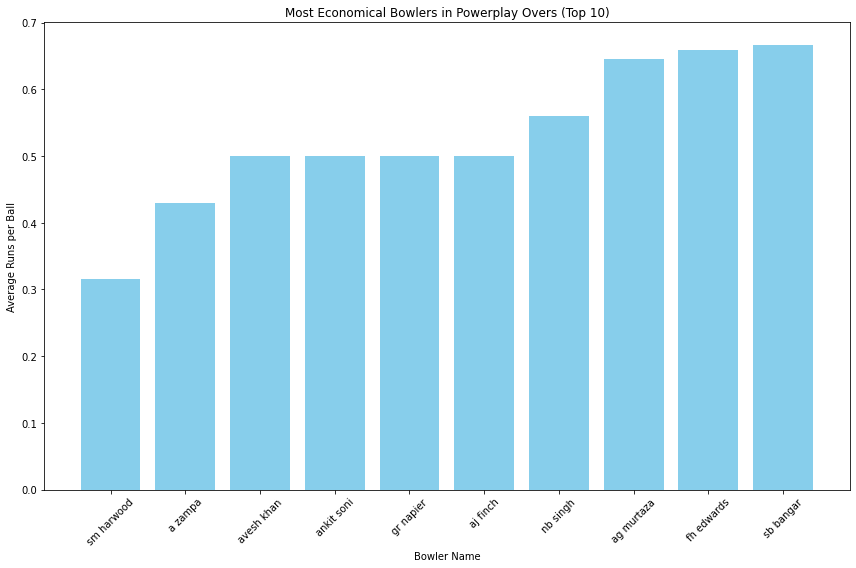

In [0]:
economical_bowlers_df = economical_bowlers_powerplay.toPandas()
# Limiting to top 10 for clarity in the plot
top_economical_bowlers = economical_bowlers_df.nsmallest(10, 'avg_runs_per_ball')

plt.figure(figsize=(12,8))
plt.bar(top_economical_bowlers['player_name'],top_economical_bowlers['avg_runs_per_ball'] , color='skyblue')
plt.xlabel('Bowler Name')
plt.ylabel('Average Runs per Ball')
plt.title('Most Economical Bowlers in Powerplay Overs (Top 10)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

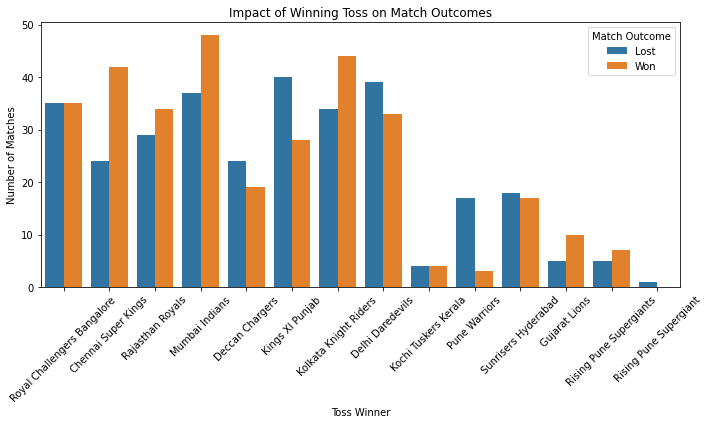

In [0]:
toss_impact_pd = toss_impact_individual_matches.toPandas()

# Creating a countplot to show win/loss after winning toss
plt.figure(figsize=(10, 6))
sbn.countplot(x='toss_winner', hue='match_outcome', data=toss_impact_pd)
plt.title('Impact of Winning Toss on Match Outcomes')
plt.xlabel('Toss Winner')
plt.ylabel('Number of Matches')
plt.legend(title='Match Outcome')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

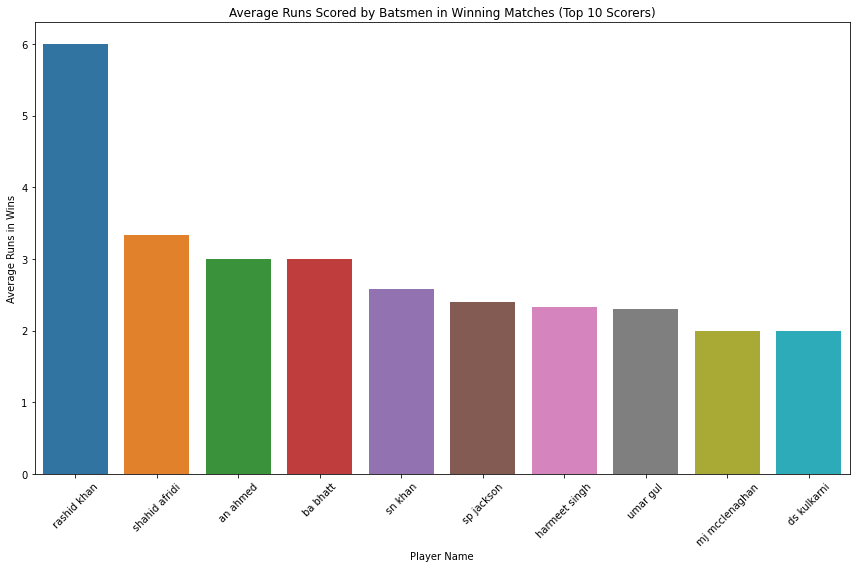

In [0]:
average_runs_pd = average_runs_in_wins.toPandas()

# Using seaborn to plot average runs in winning matches
plt.figure(figsize=(12, 8))
top_scorers = average_runs_pd.nlargest(10, 'avg_runs_in_wins')
sbn.barplot(x='player_name', y='avg_runs_in_wins', data=top_scorers)
plt.title('Average Runs Scored by Batsmen in Winning Matches (Top 10 Scorers)')
plt.xlabel('Player Name')
plt.ylabel('Average Runs in Wins')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [0]:
# Execute SQL Query
scores_by_venue = spark.sql("""
SELECT venue_name, AVG(total_runs) AS average_score, MAX(total_runs) AS highest_score
FROM (
    SELECT ball_by_ball.match_id, match.venue_name, SUM(runs_scored) AS total_runs
    FROM ball_by_ball
    JOIN match ON ball_by_ball.match_id = match.match_id
    GROUP BY ball_by_ball.match_id, match.venue_name
)
GROUP BY venue_name
ORDER BY average_score DESC
""")


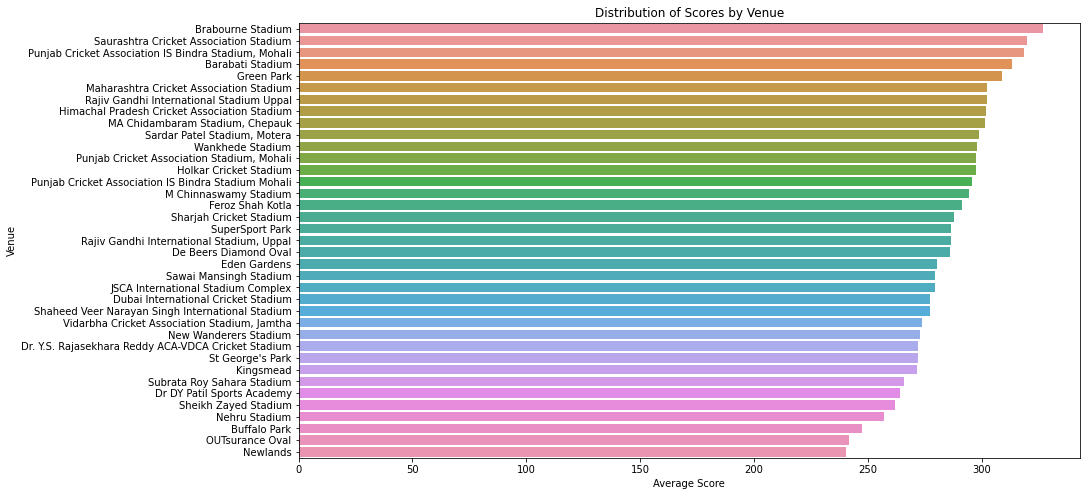

In [0]:
scores_by_venue_df = scores_by_venue.toPandas()

# Plot
plt.figure(figsize=(14, 8))
sbn.barplot(x='average_score', y='venue_name', data=scores_by_venue_df)
plt.title('Distribution of Scores by Venue')
plt.xlabel('Average Score')
plt.ylabel('Venue')
plt.show()

In [0]:
# Execute SQL Query
team1_toss_win_performance = spark.sql("""
SELECT team1, COUNT(*) AS matches_played, SUM(CASE WHEN toss_winner = match_winner THEN 1 ELSE 0 END) AS wins_after_toss
FROM match
WHERE toss_winner = team1
GROUP BY team1
ORDER BY wins_after_toss DESC
""")

team_toss_win_performance.show()

+--------------------+--------------+---------------+
|               team1|matches_played|wins_after_toss|
+--------------------+--------------+---------------+
| Chennai Super Kings|            37|             27|
|      Mumbai Indians|            42|             26|
|Kolkata Knight Ri...|            36|             24|
|Royal Challengers...|            34|             19|
|    Delhi Daredevils|            36|             17|
|    Rajasthan Royals|            25|             16|
|     Kings XI Punjab|            32|             14|
| Sunrisers Hyderabad|            16|              8|
|     Deccan Chargers|            22|              6|
|Rising Pune Super...|             6|              4|
|       Gujarat Lions|             7|              3|
|Kochi Tuskers Kerala|             4|              2|
|       Pune Warriors|            10|              2|
+--------------------+--------------+---------------+



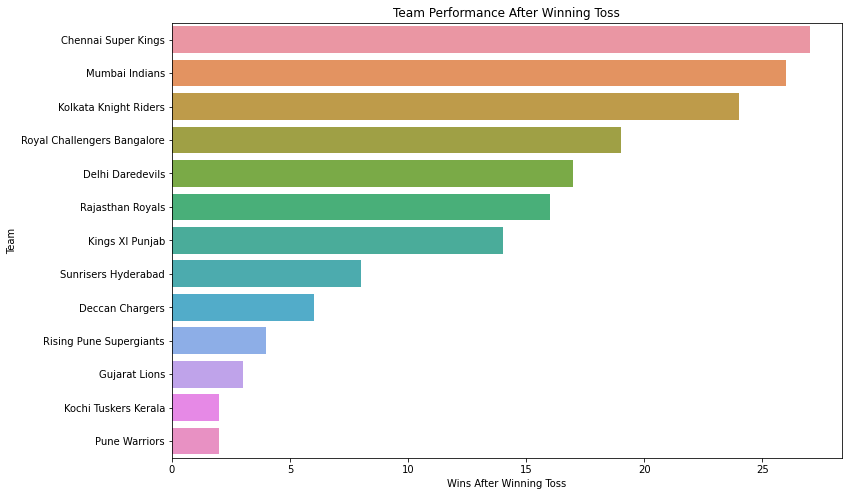

In [0]:
# Convert to Pandas DataFrame
team_toss_win_pd = team_toss_win_performance.toPandas()

# Plot
plt.figure(figsize=(12, 8))
sbn.barplot(x='wins_after_toss', y='team1', data=team_toss_win_pd)
plt.title('Team Performance After Winning Toss')
plt.xlabel('Wins After Winning Toss')
plt.ylabel('Team')
plt.show()